# Find differentially accessible peaks between clusters

In this notebook, the authors perform a differential accessibility test to find differentially accessible regions between clusters of cells. They use the same approach of logistic regression as <a href=https://www.biorxiv.org/content/10.1101/258566v2>Ntranos et al. 2018</a> for scRNA-seq data, and then add the total number of fragments as a latent variable to mitigate the effect of differential sequencing depth on the result. 

The logistic regression predicts group membership based on each feature and compares this to a null model with a likelihood ratio test.

p-value adjustment is performed using bonferroni correction based on the total number of genes in the dataset. 

Finds markers (differentially expressed genes) for identity classes

This allows us to compare different groups of cells.

In [1]:
library(Signac)
library(Seurat)
library(SeuratDisk)

Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2

Attaching SeuratObject


Attaching package: 'Seurat'


The following object is masked from 'package:Signac':

    FoldChange


Registered S3 method overwritten by 'cli':
  method     from         
  print.boxx spatstat.geom

Registered S3 method overwritten by 'SeuratDisk':
  method            from  
  as.sparse.H5Group Seurat



In [2]:
brain <- readRDS("./adult_mouse_brain/Outputs/brain_coaccs.rds")

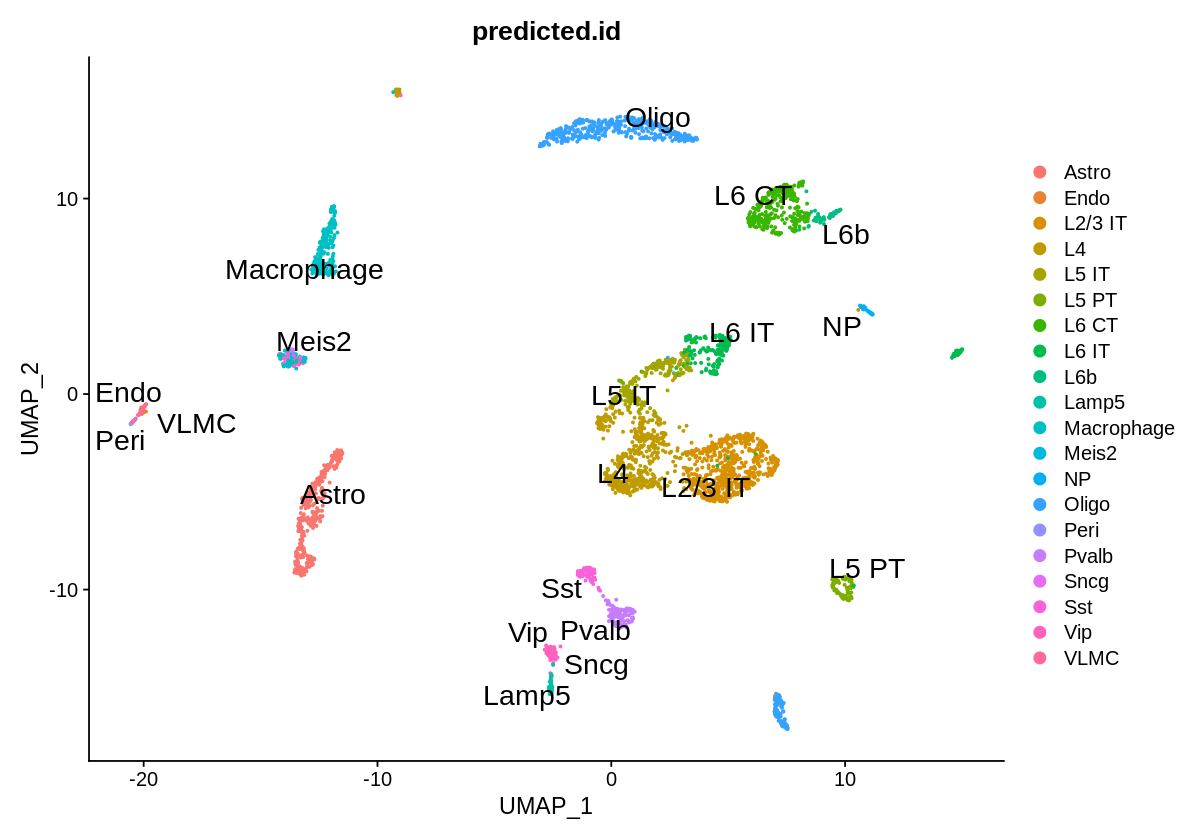

In [3]:
options(repr.plot.width=10, repr.plot.height=7)
DimPlot(brain, group.by = "predicted.id", label = TRUE, label.size = 6, repel = TRUE)

In [4]:
#switch back to working with peaks instead of gene activities
DefaultAssay(brain) <- 'ATAC'

#groups of cells to compare
group1 = c("L2/3 IT")
group2 = c("L4", "L5 IT", "L6 IT")

In [5]:
da_peaks <- FindMarkers(
  object = brain,
  ident.1 = group1, 
  ident.2 = group2,
  min.pct = 0.4,
  test.use = 'LR',
  latent.vars = 'peak_region_fragments')

head(da_peaks)

,p_val,avg_log2FC,pct.1,pct.2,p_val_adj
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
chr4-86523678-86525285,3.413350e-67,0.8098730,0.401,0.036,5.365888e-62
chr15-87605281-87607659,2.945028e-59,0.7262452,0.485,0.090,4.629672e-54
chr2-118700082-118704897,5.135950e-57,0.4401448,0.622,0.180,8.073868e-52
chr3-137056475-137058371,9.571201e-53,0.5114632,0.523,0.103,1.504621e-47
chr13-69329933-69331707,1.019300e-52,-0.6129178,0.143,0.445,1.602370e-47
chr10-107751762-107753240,2.126567e-51,0.5680184,0.611,0.185,3.343027e-46


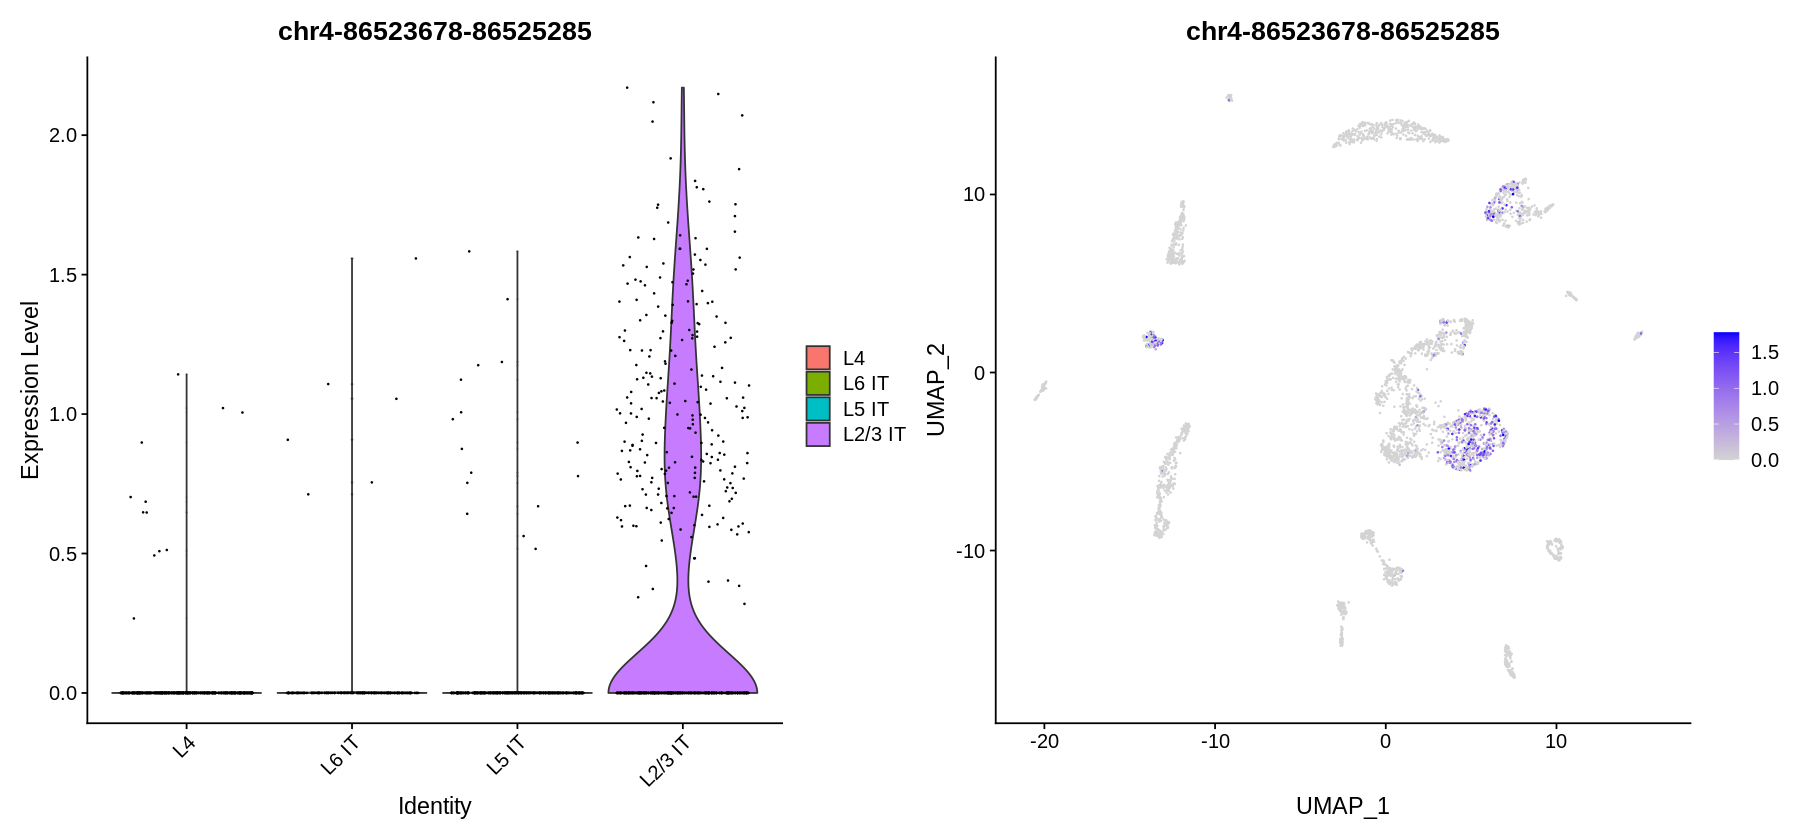

In [6]:
plot1 <- VlnPlot(
  object = brain,
  features = rownames(da_peaks)[1],
  pt.size = 0.1,
  idents = c(group2,group1)
)
plot2 <- FeaturePlot(
  object = brain,
  features = rownames(da_peaks)[1],
  pt.size = 0.1,
  max.cutoff = 'q95'
)
options(repr.plot.width=15, repr.plot.height=7)
plot1 | plot2

We can also take a look at the fold change accessibility (in peaks) to find DA regions between two groups of cells. It is faster than the logistic regression approach, but we cannot take into account latent variables and we do not have statistical tests.

In [7]:
fc <- FoldChange(brain, ident.1 = group1, ident.2 = group2)
head(fc)

,avg_log2FC,pct.1,pct.2
,<dbl>,<dbl>,<dbl>
chr1-3094708-3095552,-0.02779605,0.096,0.089
chr1-3119414-3121782,-0.17584055,0.305,0.363
chr1-3204809-3205178,0.20802773,0.059,0.025
chr1-3217330-3217359,0.28049340,0.007,0.006
chr1-3228123-3228463,-0.02444753,0.049,0.038
chr1-3292446-3293365,0.08488047,0.192,0.111


We can find the closest gene to each of the peaks for a better interpretation.

In [8]:
open_l23 <- rownames(da_peaks[da_peaks$avg_log2FC > 0.25, ])
open_l456 <- rownames(da_peaks[da_peaks$avg_log2FC < -0.25, ])
closest_l23 <- ClosestFeature(brain, regions = open_l23)
closest_l456 <- ClosestFeature(brain, regions = open_l456)

In [9]:
head(closest_l23)

,tx_id,gene_name,gene_id,gene_biotype,type,closest_region,query_region,distance
,<chr>,<chr>,<chr>,<chr>,<fct>,<chr>,<chr>,<int>
ENSMUST00000151481,ENSMUST00000151481,Fam154a,ENSMUSG00000028492,protein_coding,gap,chr4-86487920-86538964,chr4-86523678-86525285,0
ENSMUSE00000647021,ENSMUST00000068088,Fam19a5,ENSMUSG00000054863,protein_coding,exon,chr15-87625230-87625486,chr15-87605281-87607659,17570
ENSMUST00000104937,ENSMUST00000104937,Ankrd63,ENSMUSG00000078137,protein_coding,cds,chr2-118702266-118703438,chr2-118700082-118704897,0
ENSMUST00000070198,ENSMUST00000070198,Ppp3ca,ENSMUSG00000028161,protein_coding,utr,chr3-136935226-136937727,chr3-137056475-137058371,118747
ENSMUST00000165341,ENSMUST00000165341,Otogl,ENSMUSG00000091455,protein_coding,utr,chr10-107762223-107762309,chr10-107751762-107753240,8982
ENSMUST00000179893,ENSMUST00000179893,Ryr1,ENSMUSG00000030592,protein_coding,cds,chr7-29073019-29073139,chr7-29070299-29073172,0


We could follow up this result further by doing gene ontology enrichment analysis on the gene sets returned by ClosestFeature(), and there are many R packages that can do this (see the GOstats package for example).

## Plotting genomic regions

Create coverage plots grouped by cluster, cell type or any other metadata stored for any genomic region.

Warning message:
"Removed 7 rows containing missing values (position_stack)."
Warning message:
"Removed 1 rows containing missing values (position_stack)."


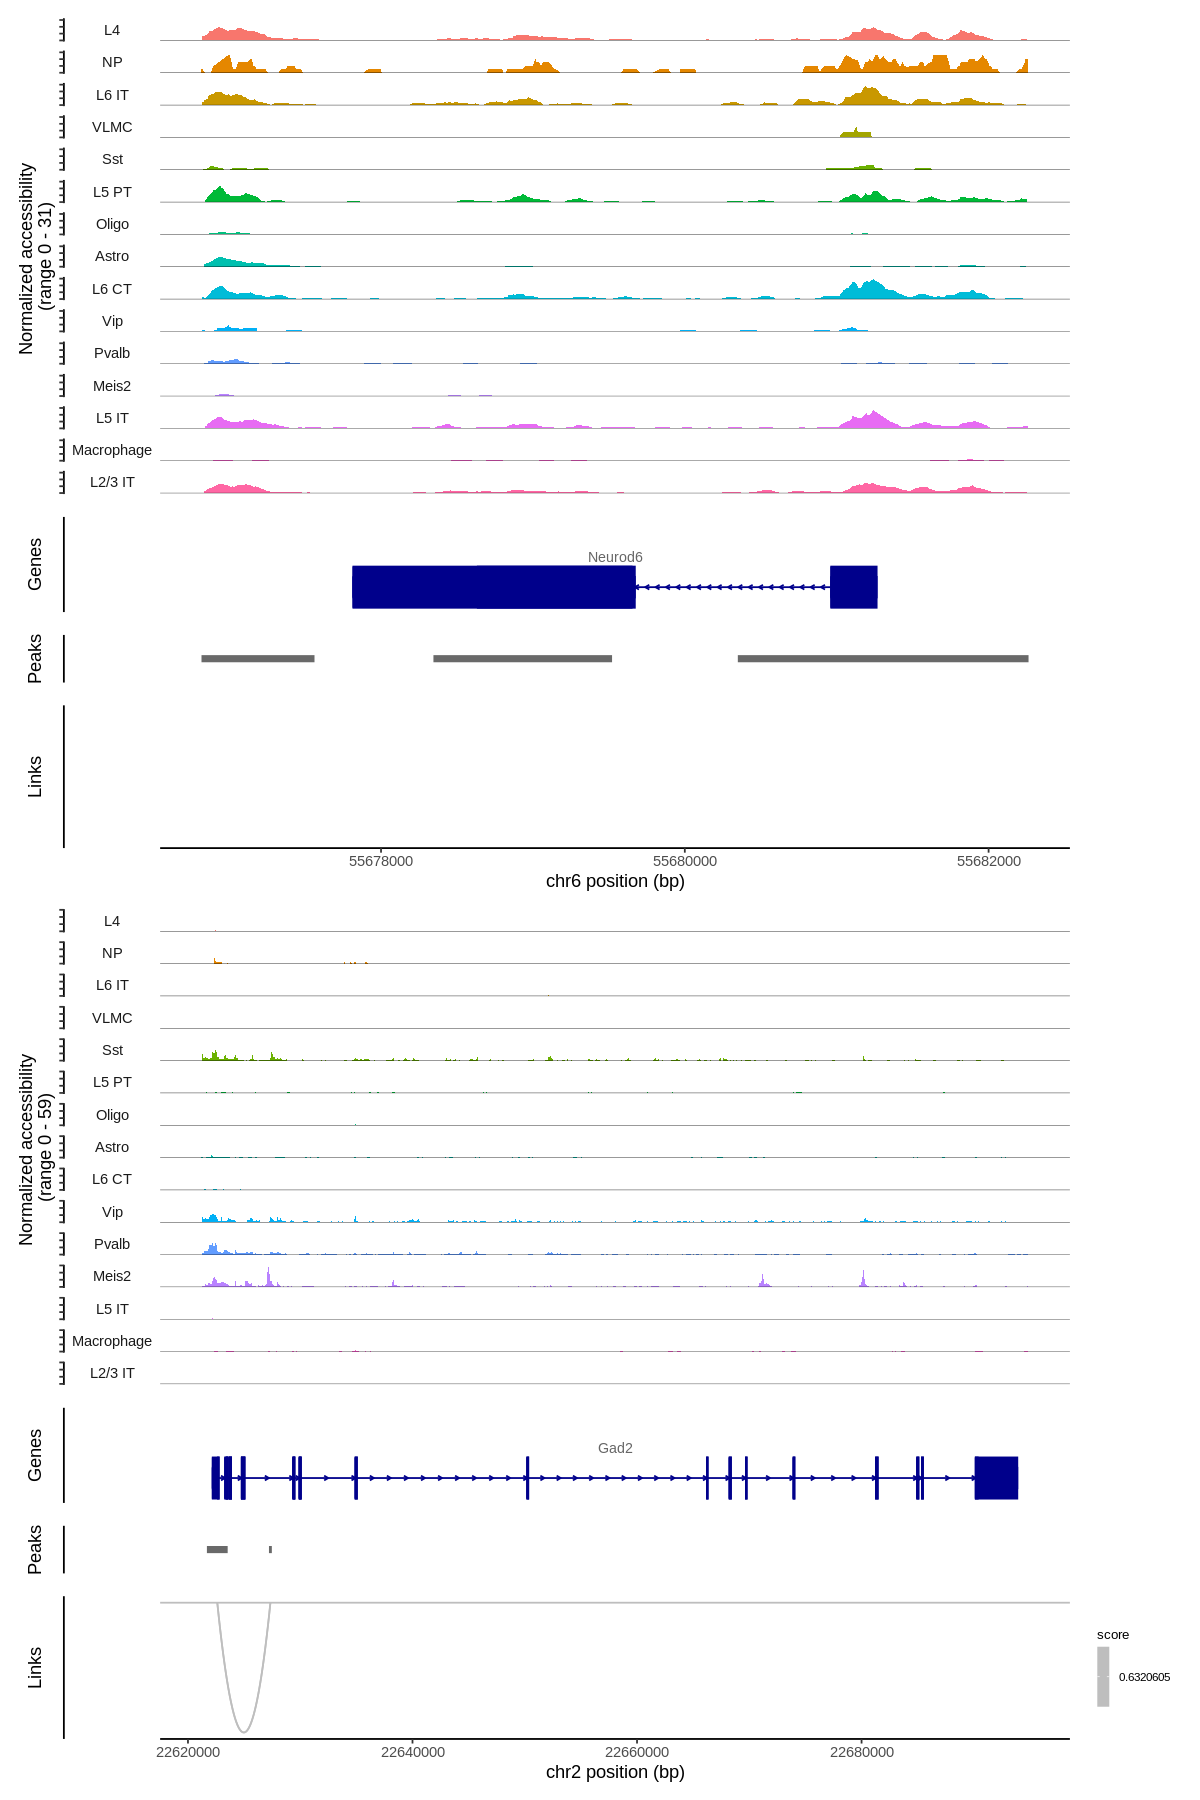

In [10]:
options(repr.plot.width=10, repr.plot.height=15)
CoveragePlot(
  object = brain,
  region = c("Neurod6", "Gad2"),
  extend.upstream = 1000,
  extend.downstream = 1000,
  ncol = 1
)